In [ ]:
import os
import pydicom
import rpc3dl

from rpc3dl.files._dicom_util import hierarchy

In [ ]:
root = r"D:\testfolder\sample"
filepaths = [os.path.join(root,file) for file in os.listdir(root)]
dcms = [pydicom.dcmread(path) for path in filepaths]

In [ ]:
x = hierarchy(dcms,level='modality')

In [ ]:
x.keys()

In [ ]:
series = []
for file in x['CT']:
    series.append(file.SeriesInstanceUID)
series = list(set(series))
print(series)

In [ ]:
plan = x['RTPLAN'][0]

In [ ]:
plan.ReferencedStructureSetSequence[0]

In [ ]:
dose = x['RTDOSE'][0]

In [ ]:
for ss in x['RTSTRUCT']:
    if ss.SOPInstanceUID == plan.ReferencedStructureSetSequence[0].ReferencedSOPInstanceUID:
        break

In [ ]:
ss.ReferencedFrameOfReferenceSequence[0].RTReferencedStudySequence[0].RTReferencedSeriesSequence[0].SeriesInstanceUID

In [ ]:
def filter_dcms(dcms):
    # check to ensure only one study
    check = hierarchy(dcms,level='study')
    assert len(list(check.keys())) == 1
    
    modsort = hierarchy(dcms,level='modality')
    # first we get our plan file - if only one, we accept
    # if more than one, look for approved status
    if len(modsort['RTPLAN']) == 1:
        plan = modsort['RTPLAN'][0]
    else:
        plan = None
        for planfile in modsort['RTPLAN']:
            if planfile.ApprovalStatus == 'APPROVED':
                plan = planfile
                break
        assert plan is not None
    
    refUID = plan.ReferencedStructureSetSequence[0].ReferencedSOPInstanceUID
    ss = None
    for ssfile in modsort['RTSTRUCT']:
        if ssfile.SOPInstanceUID == refUID:
            ss = ssfile
            break
    imgrefUID = ss.ReferencedFrameOfReferenceSequence[0].RTReferencedStudySequence[0].RTReferencedSeriesSequence[0].SeriesInstanceUID
    keep_cts = []
    for ct in modsort['CT']:
        if ct.SeriesInstanceUID == imgrefUID:
            keep_cts.append(ct)
    # provision for the sometimes failure to transfer dose files from MIM
    if 'RTDOSE' not in modsort.keys():
        dosefiles = []
    else:
        dosefiles = modsort['RTDOSE']
    
    allfiles = [plan] + [ss] + keep_cts + dosefiles
    return allfiles
            

In [ ]:
len(dcms)

In [ ]:
filtered = filter_files(dcms)
print(len(filtered))

In [ ]:
destdir = r"D:/testfolder/filtered"
mapper = {
    "CT" : "CT",
    "RTSTRUCT" : "RS",
    "RTDOSE" : "RD",
    "RTPLAN" : "RP"
    }
    
for i,file in enumerate(filtered):
    modality = mapper[str(file.Modality)]
    ptid = str(file.PatientID)
    file.save_as(os.path.join(destdir,"{}_{}_{}.dcm".format(modality,ptid,i)))

In [ ]:
dose = x['RTDOSE'][0]

In [ ]:
ct = filtered[30]

In [ ]:
import matplotlib.pyplot as plt

In [1]:
import h5py

In [7]:
with h5py.File(r"D:/testfolder/test.h5","r") as f:
    print(f.keys())

<KeysViewHDF5 ['augment_1', 'augment_2', 'base', 'pt_chars']>


In [10]:
def get_dataset():
    f2 = h5py.File(r"D:/testfolder/test.h5", 'r')
    print(f2.attrs.keys())
    print('label',f2.attrs['label'])
    return f2['base'], f2['pt_chars']
ds, pc = get_dataset()

<KeysViewHDF5 ['label']>
label 12


In [12]:
pc[...]

array([  1,   2,   3,   4, 789])

In [ ]:
plt.imshow(ds[20,:,:,2],cmap='gray')

In [3]:
import numpy as np

In [9]:
with h5py.File(r"D:/testfolder/test.h5","a") as f:
    if 'pt_chars' in f.keys():
        del f['pt_chars']
    f.create_dataset('pt_chars',data=np.array([1,2,3,4,789]))
    f.close()

In [14]:
import h5py
import numpy as np

In [15]:
with h5py.File("test.h5","w") as f:
    f.create_dataset("base",data=np.ones((40,128,128,3)))
    lblgrp = f.create_group("labels")
    lblgrp.attrs['early'] = 1
    lblgrp.attrs['late'] = 0
    lblgrp.attrs['all'] = 1
    lblgrp.attrs['desc'] = 'sticky_saliva>=3,dry_mouth>=3'

In [19]:
with h5py.File("test.h5","r") as f:
    print('labels' in f.keys())

True


In [20]:
import matplotlib.pyplot as plt

In [21]:
f = h5py.File(r"D:\testfolder\testfile.h5","r")
data = f['base'][...]

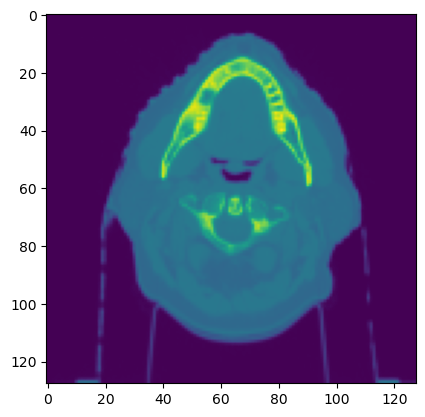

In [22]:
plt.imshow(data[20,:,:,0])